<h3 style="font-family: Times New Roman"><strong>Training CNN Model using MNIST Dataset</strong></h3>

<div style="font-family: Times New Roman; font-size: 15px">
For this demonstration we will be using MNIST dataset which is a popular dataset in training deep learning models.
</div>

<h4 style="font-family: Times New Roman"><strong>Import Standard Libraries</strong></h4>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

torch.backends.cudnn.deterministic=True
torch.set_printoptions(sci_mode=False)

import time
from tqdm.notebook import tqdm

<p style="font-family:Times New Roman; text-align:justify; font-size:15px">
<strong><tt>torchvision.datasets</tt></strong> module provides a variety of datasets that are commonly used for training machine learning and deep learning models. These datasets are preprocessed and can be easily integrated into PyTorch workflows for tasks such as image classification, object detection, and more. Dataset includes:
<ul>
    <li>MNIST</li>
    <li>CIFAR10</li>
    <li>CIFAR100</li>
    <li>ImageNet</li>
</ul>
</div>

In [3]:
# `transforms` is used to apply augmentation techniques and modification to the image data (e.g, rotate, resize, normalization, etc.).
# for this one, let's just convert the image arrays to tensor.
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [4]:
# the training data have 60,000 images, let's take a small portion from it for the validation.
# what's the importance of validation data?
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
# unseen images
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
# 50,000 for training and 10,000 for validation
train_set, val_set = torch.utils.data.random_split(train_data, [0.8, 0.2])

In [9]:
# function to set the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

<p style="font-family:Times New Roman; text-align:justify; font-size:15px">
PyTorch provides two data primitives: <strong><tt>torch.utils.data.DataLoader</tt></strong> and <strong><tt>torch.utils.data.Dataset</tt></strong> that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.
</p>

In [12]:
set_seed(143)

batch_size = 10

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [13]:
set_seed(143)
images, labels = iter(train_loader).__next__()

def display_image(batch):
    batch = batch.detach().numpy()
    fig, axs = plt.subplots(1, len(batch), figsize=(12, 2))
    for i in range(len(batch)):
        axs[i].imshow(batch[i, 0, :, :], vmin=0, vmax=1)
        axs[i].axis('off')
        axs[i].set_title(labels[i].numpy())
    plt.show()

<p style="font-family:Times New Roman; text-align:justify; font-size:15px">
For this demonstration, we will use the following architecture: it consists of two convolutional layers, each followed by its own max-pooling layer and activation function. Additionally, there are two fully connected layers, with the second layer using the softmax activation function.
</div>

<center><img src ="figures/lecture_model.png"></center>

<h4 style="font-family: Times New Roman"><strong>Input Images</strong></h4>

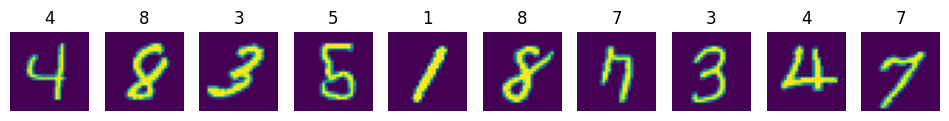

torch.Size([10, 1, 28, 28])


In [14]:
display_image(images)
print(images.shape)

# (b, c, h, w)

$$\text{Output Shape} = \frac{\text{input width} - \text{filter} + 2 \cdot \text{padding}}{\text{stride} + 1}$$

In [15]:
def calc_out(w, f, s, p):
    """
    Calculate output shape of a matrix after a convolution.
    The results are only applicable for square matrix kernels and images only.
    """
    print(f'Output Shape: {(w - f + 2 * p) // s + 1}')

<h4 style="font-family: Times New Roman"><strong>First Convolution Layer + Activation Function</strong></h4>

In [19]:
# The first convolution must output a 28 by 28 image size
calc_out(28, 3, 1, 1)

Output Shape: 28


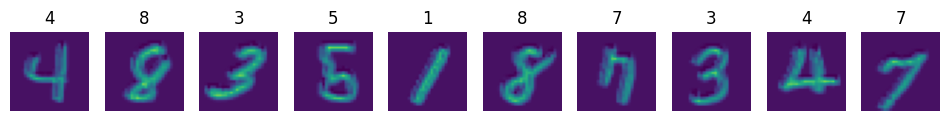

torch.Size([10, 32, 28, 28])


In [20]:
conv1 = nn.Conv2d(1, 32, (3,3), 1, 1)

x = F.relu(conv1(images))
display_image(x)
print(x.shape)

<h4 style="font-family: Times New Roman"><strong>First Pooling (MaxPooling)</strong></h4>

In [21]:
# first maxpooling must output a 14 by 14 size
calc_out(28, 2, 2, 0)

Output Shape: 14


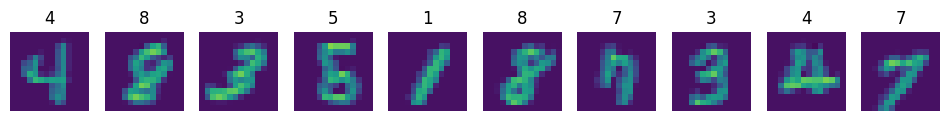

torch.Size([10, 32, 14, 14])


In [22]:
pool1 = nn.MaxPool2d((2,2), 2)

x = pool1(x)
display_image(x)
print(x.shape)

<h4 style="font-family: Times New Roman"><strong>Let's examine the feature map.</strong></h4>

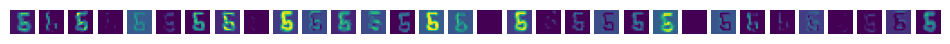

In [23]:
idx = 3
feature_maps =  x[idx].view((1, 32, 14, 14)).detach().numpy()
fig, axs = plt.subplots(1, 32, figsize=(12, 2))
for i in range(32):
    axs[i].imshow(feature_maps[0, i, :, :], vmin=0, vmax=1)
    axs[i].axis('off')

<h4 style="font-family: Times New Roman"><strong>Second Convolution</strong></h4>

In [28]:
calc_out(14, 3, 1, 1)

Output Shape: 14


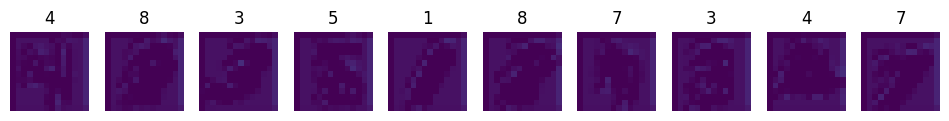

torch.Size([10, 64, 14, 14])


In [29]:
conv2 = nn.Conv2d(32, 64, (3,3), 1, 1)

x = F.relu(conv2(x))
display_image(x)
print(x.shape)

<h4 style="font-family: Times New Roman"><strong>Second Pooling (MaxPooling)</strong></h4>

In [30]:
calc_out(14, 2, 2, 0)

Output Shape: 7


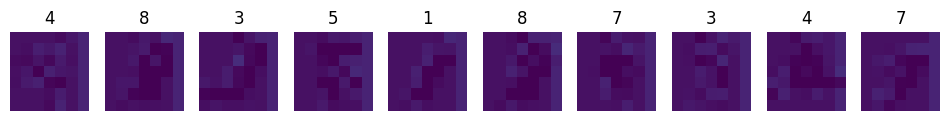

torch.Size([10, 64, 7, 7])


In [31]:
pool2 = nn.MaxPool2d((2,2), 2)

x = pool2(x)
display_image(x)
print(x.shape)

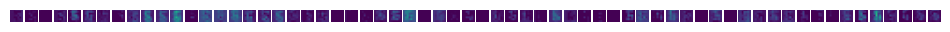

In [33]:
idx = 3
feature_maps =  x[idx].view((1, 64, 7, 7)).detach().numpy()
fig, axs = plt.subplots(1, 64, figsize=(12, 2))
for i in range(64):
    axs[i].imshow(feature_maps[0, i, :, :], vmin=0, vmax=1)
    axs[i].axis('off')

<h4 style="font-family: Times New Roman"><strong>Flatten</strong></h4>

In [35]:
flat = x.view((-1, 64*7*7))

fcn1 = nn.Linear(64*7*7, 128)
fcn2 = nn.Linear(128, 10)

out = fcn1(flat)
out = F.softmax(fcn2(out), dim=1)

In [36]:
# prediction
# assess the prediction
[i.argmax().item() for i in out]

[8, 4, 4, 4, 4, 4, 4, 8, 4, 4]

In [37]:
# true label
[i.item() for i in labels]

[4, 8, 3, 5, 1, 8, 7, 3, 4, 7]

<p style="font-family:Times New Roman; text-align:justify; font-size:15px">
<strong>QUESTION:</strong> <br> Why is it that the true and the predicted value is very distant from each other?
</p>

<h4 style="font-family: Times New Roman"><strong>Now let's put them all together</strong></h4>

In [40]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # just the initialization
        self.conv1 = nn.Conv2d(1, 32, (3,3), 1, 1)
        self.pool1 = nn.MaxPool2d((2,2), 2)
        self.conv2 = nn.Conv2d(32, 64, (3,3), 1, 1)
        self.pool2 = nn.MaxPool2d((2,2), 2)
        self.fcn1 = nn.Linear(64*7*7, 128)
        self.fcn2 = nn.Linear(128, 10)

    def forward(self, x):
        # seuential
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 64*7*7)
        x = self.fcn1(x)
        x = F.softmax(self.fcn2(x), dim=1)
        
        return x

<h4 style="font-family: Times New Roman"><strong>Instantiate the Class</strong></h4>

In [41]:
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fcn1): Linear(in_features=3136, out_features=128, bias=True)
  (fcn2): Linear(in_features=128, out_features=10, bias=True)
)

<p style="font-family:Times New Roman; text-align:justify; font-size:15px">Model Parameters: </p>

$\quad\begin{align}(1\times32\times3\times3)+32+(32\times64\times3\times3)+64+(3136\times128)+128+(128\times10)+10 &=\\
288+32+18432+64+401408+128+1280+10 &= 421,642\end{align}$<br>

In [42]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

   288
    32
 18432
    64
401408
   128
  1280
    10
______
421642


<h4 style="font-family: Times New Roman"><strong>Define Criterion and Optimizer</strong></h4>

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [45]:
# if your device has cuda enabled gpu, you can use it to accelerate the training process.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

model = model.to(device)

cuda


<h4 style="font-family: Times New Roman"><strong>Let's walk through the training loop</strong></h4>
<div class="alert alert-info">
    
```python
for e in range(epochs):
    train_corr = 0
    val_corr = 0
```

This will iterate `5` times as what is defined below. `train_corr` and `val_corr` serves as temporary place holders for correctly predicted train data and correctly predicted validation data. Hence, `train_corr` and `val_corr` will be re-initialized to `0` again if an entire epoch is done.<br>

```python
    for train_b, (x_train, y_train) in tqdm(enumerate(train_loader)):
        train_b += 1
        x_train = x_train.to(device)
        y_train = y_train.to(device)
```

The second loop (nested loop) iterates over the `train_loader`. A single iteration of the `train_loader` is equal to `1` batch of features and targets, our batch size is 10, therefore in every iteration of the `train_loader` we are processing `10` instances. The entire training set or the `len(train_loader.dataset)` is `50,000`. Therefore, to finish an entire epoch, we need to process `5000` batches with a batch size of `10` (5000 x 10 = 50,000).<br>


**NOTE:**
When an iterable object is wrapped around an `enumerate` function, the output will return an index for each iterated values. `train_b` is the number of batches that has been processed.

The `to()` functions next to the `x_train` and `y_train` are simply there to move the data into the available computing device. Remember that you need to move the `model` as well to the available device.<br>

**OUTPUT:**

`x_train.shape` = `torch.Size([10, 1, 28, 28])`

`y_train.shape` = `torch.Size([10])`

```python
        train_pred = model(x_train)
        train_loss = criterion(train_pred, y_train)

        train_pred_vec = torch.max(train_pred.data, 1)[1]
        train_corr += (train_pred_vec == y_train).sum()
```
`train_pred` represents the model's predictions for the current batch. The shape of train_pred is `torch.Size([10, 10])`. Each row in `train_pred` corresponds to an instance in the batch, and each column represents a class. The values in each row indicate the model's estimated probabilities or scores for each class for that instance. <br>
`train_loss` is a scalar value of the error that was calculated from that particular batch. <br>
`train_pred_vec` is a vector that contained the predicted labels of the current batch. The values are integer that ranges from 0 to 9. `train_pred_vec.shape` is `torch.Size([10])`, the values represents each predicted label of each instance. <br>
`train_corr` performs comparison operation to check how many samples in the batch was correctly predicted, the value of the `train_corr` will be inceremented, but will be re-initialized back to 0 when an entire epoch is done.<br>

```python
        # Update parameters
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
```
We need to update the parameters for every batch that passes in every epoch, we can do this by applying `zero_grad()` to the optimizer, this will clear the gradients for the next batch, if we don't do that, the gradients will accumulate for every batch for the entire epoch. <br>

`train_loss.backward()` is used to compute the gradients of the loss with respect to the model's parameters during the backward pass of the training process. It's a fundamental step in the training loop of a neural network.<br>

`optimizer.step()` is a method used to update the parameters (weights and biases) of a neural network model during the training process. It is called after the gradients of the model's parameters have been computed during the backward pass.

```python
        if train_b % 1250 == 0:
            print(f"epoch: {e+1:2} | batch: {train_b:4} | instances: [{train_b*batch_size:6} / {len(train_loader)  * batch_size}] | loss: {train_loss.item()}")
            print(f"✅{train_corr.item()} of {train_b*batch_size:2} | accuracy: {round(((train_corr.item() / (train_b*batch_size))) * 100 , 3)}%")
```
This prints training progress information during each batch iteration in a concise format. It displays the current epoch, batch number, the number of processed instances, the loss, and the accuracy achieved up to that point in training.

```python
        train_correct.append(train_corr.item())
        train_losses.append(train_loss.item())
```
Appends current the batch's `train_corr` and `train_loss` on the empty lists outside the epoch.

```python
    with torch.no_grad():
        for val_b, (x_val, y_val) in enumerate(val_loader):
            val_b += 1
            
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            val_pred = model(x_val)
            val_pred_vec = torch.max(val_pred.data, 1)[1]
            val_corr += (val_pred_vec == y_val).sum()

            val_loss = criterion(val_pred, y_val)
            val_correct.append(val_corr.item())
            val_losses.append(val_loss.item())
            
            val_acc = val_corr.item() / (len(val_loader) * batch_size)
            
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"model/best_{model._get_name()}.pth")
            print(f"\t📁New best model saved! | accuracy: {best_acc*100}%")
    
    train_epoch_acc = train_corr.item() / (batch_size * len(train_loader))
    val_epoch_acc = val_corr.item() / (batch_size * len(val_loader))
    
    train_accs.append(train_epoch_acc)
    val_accs.append(val_epoch_acc)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')
```
This part of the code performs the evaluation of the trained model for every epoch, the code is quite similar to the training process but without the updating of parameters. The code also have features of saving the `state_dict` (trained parameters) of the model with best accuracy.





</div>

In [46]:
set_seed(42)
epochs = 5
start_time = time.time()
best_acc = 0.0

train_correct = []
train_losses = []
train_accs = []

val_correct = []
val_losses = []
val_accs = []

for e in range(epochs):
    train_corr = 0
    val_corr = 0
    
    for train_b, (x_train, y_train) in tqdm(enumerate(train_loader)):
        train_b += 1
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        train_pred = model(x_train)
        train_loss = criterion(train_pred, y_train)

        train_pred_vec = torch.max(train_pred.data, 1)[1] # prediction vector
        train_corr += (train_pred_vec == y_train).sum()

        # Update parameters
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if train_b % 1250 == 0:
            print(f"epoch: {e+1:2} | batch: {train_b:4} | instances: [{train_b*batch_size:6} / {len(train_loader)  * batch_size}] | loss: {train_loss.item()}")
            print(f"✅{train_corr.item()} of {train_b*batch_size:2} | accuracy: {round(((train_corr.item() / (train_b*batch_size))) * 100 , 3)}%")

        train_correct.append(train_corr.item())
        train_losses.append(train_loss.item())

    with torch.no_grad():
        for val_b, (x_val, y_val) in enumerate(val_loader):
            val_b += 1
            
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            val_pred = model(x_val)
            val_pred_vec = torch.max(val_pred.data, 1)[1]
            val_corr += (val_pred_vec == y_val).sum()

            val_loss = criterion(val_pred, y_val)
            val_correct.append(val_corr.item())
            val_losses.append(val_loss.item())
            
            val_acc = val_corr.item() / (len(val_loader) * batch_size)
            
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"model/best_{model._get_name()}.pth")
            print(f"\t📁New best model saved! | accuracy: {best_acc*100}%")
    
    train_epoch_acc = train_corr.item() / (batch_size * len(train_loader))
    val_epoch_acc = val_corr.item() / (batch_size * len(val_loader))
    
    train_accs.append(train_epoch_acc)
    val_accs.append(val_epoch_acc)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

0it [00:00, ?it/s]

epoch:  1 | batch: 1250 | instances: [ 12500 / 48000] | loss: 1.5471436977386475
✅10995 of 12500 | accuracy: 87.96%
epoch:  1 | batch: 2500 | instances: [ 25000 / 48000] | loss: 1.561285138130188
✅22813 of 25000 | accuracy: 91.252%
epoch:  1 | batch: 3750 | instances: [ 37500 / 48000] | loss: 1.464577078819275
✅34775 of 37500 | accuracy: 92.733%
	📁New best model saved! | accuracy: 95.975%


0it [00:00, ?it/s]

epoch:  2 | batch: 1250 | instances: [ 12500 / 48000] | loss: 1.4611502885818481
✅12080 of 12500 | accuracy: 96.64%
epoch:  2 | batch: 2500 | instances: [ 25000 / 48000] | loss: 1.5607588291168213
✅24202 of 25000 | accuracy: 96.808%
epoch:  2 | batch: 3750 | instances: [ 37500 / 48000] | loss: 1.4611502885818481
✅36297 of 37500 | accuracy: 96.792%
	📁New best model saved! | accuracy: 96.55833333333334%


0it [00:00, ?it/s]

epoch:  3 | batch: 1250 | instances: [ 12500 / 48000] | loss: 1.5611584186553955
✅12088 of 12500 | accuracy: 96.704%
epoch:  3 | batch: 2500 | instances: [ 25000 / 48000] | loss: 1.4611502885818481
✅24245 of 25000 | accuracy: 96.98%
epoch:  3 | batch: 3750 | instances: [ 37500 / 48000] | loss: 1.4611502885818481
✅36394 of 37500 | accuracy: 97.051%
	📁New best model saved! | accuracy: 97.58333333333333%


0it [00:00, ?it/s]

epoch:  4 | batch: 1250 | instances: [ 12500 / 48000] | loss: 1.6611244678497314
✅12135 of 12500 | accuracy: 97.08%
epoch:  4 | batch: 2500 | instances: [ 25000 / 48000] | loss: 1.4611502885818481
✅24257 of 25000 | accuracy: 97.028%
epoch:  4 | batch: 3750 | instances: [ 37500 / 48000] | loss: 1.4611502885818481
✅36361 of 37500 | accuracy: 96.963%


0it [00:00, ?it/s]

epoch:  5 | batch: 1250 | instances: [ 12500 / 48000] | loss: 1.4611502885818481
✅12184 of 12500 | accuracy: 97.472%
epoch:  5 | batch: 2500 | instances: [ 25000 / 48000] | loss: 1.4611502885818481
✅24327 of 25000 | accuracy: 97.308%
epoch:  5 | batch: 3750 | instances: [ 37500 / 48000] | loss: 1.4611502885818481
✅36528 of 37500 | accuracy: 97.408%

Duration: 192 seconds


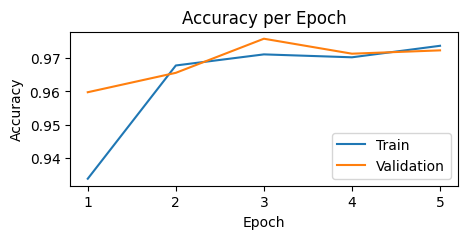

In [47]:
plt.figure(figsize=(5,2))
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.xticks(ticks=range(0,5), labels=list(range(1,6)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

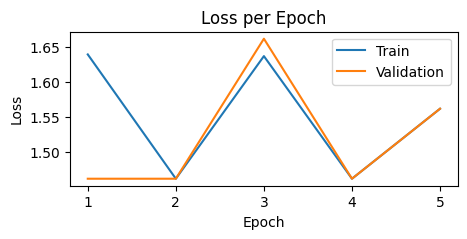

In [30]:
plt.figure(figsize=(5,2))
plt.plot([train_losses[i-1] for i in range(5000, len(train_losses)+1, 5000)], label="Train")
plt.plot([val_losses[i-1] for i in range(1000, len(val_losses)+1, 1000)], label="Validation")
plt.xticks(ticks=range(0,5), labels=list(range(1,6)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

<h4 style="font-family: Times New Roman"><strong>Testing</strong></h4>

In [48]:
true_labels = []
pred_labels = []

with torch.no_grad():
    for b, (x_test, y_test) in enumerate(test_loader):
        
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        test_pred = model(x_test)
        test_pred_vec = torch.max(test_pred.data, 1)[1]

        true_labels.append(y_test)
        pred_labels.append(test_pred_vec)

In [49]:
true_labels = torch.cat(true_labels, dim=0)
pred_labels = torch.cat(pred_labels, dim=0)

<h4 style="font-family: Times New Roman"><strong>Classification Matrix</strong></h4>

In [50]:
[v for k,v in train_data.class_to_idx.items()]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [51]:
true_labels

tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')

In [52]:
pred_labels

tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')

In [53]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:3}'))
print(np.array([v for k,v in train_data.class_to_idx.items()]), '\n')
print(confusion_matrix(true_labels.to('cpu'), pred_labels.to('cpu')))

[  0   1   2   3   4   5   6   7   8   9] 

[[974   1   0   1   0   1   2   1   0   0]
 [  0 1128   1   2   1   1   1   1   0   0]
 [  7  11 989   9   1   0   0  11   2   2]
 [  0   0   0 1001   0   3   0   3   0   3]
 [  1   1   2   0 968   0   3   2   1   4]
 [  1   0   0   6   0 874  10   1   0   0]
 [  6   2   0   0   1   1 947   0   1   0]
 [  0   6   8   2   1   0   0 1003   1   7]
 [  4  15   1   1   3   3  15   3 899  30]
 [  5   4   0   4   5   5   0   5   0 981]]


<h4 style="font-family: Times New Roman"><strong>Let's assess the misses</strong></h4>

In [54]:
true_labels

tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')

In [55]:
misses = np.array([])
missed_label = np.array([])

for i in range(len(pred_labels.to('cpu'))):
    if pred_labels[i] != true_labels.to('cpu')[i]:
        misses = np.append(misses,i).astype('int64')
        missed_label = np.append(missed_label, true_labels.to('cpu')[i]).astype('int64')

len(misses)

236

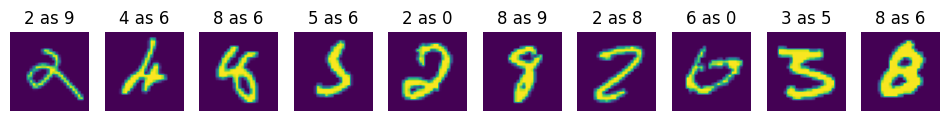

In [57]:
wrong = [pred_labels[i].item() for i in misses[:10]]
missed_images = [test_loader.dataset[j][0] for j in [i for i in misses[:10]]]
fig, axs = plt.subplots(1, len(missed_images), figsize=(12, 2))

c = 0
for i in missed_images:
    axs[c].imshow(i.view(28, 28), vmin=0, vmax=1)
    axs[c].axis('off')
    axs[c].set_title(f"{missed_label[c]} as {wrong[c]}")
    c += 1
plt.show()

<div class="alert alert-block alert-success" style="font-family: Times New Roman">
    <h4><strong>Laboratory Activty</strong></h4>

<p style="font-family:Times New Roman; text-align:justify; font-size:15px">
    <b>Instruction:</b> Convert the following CNN architecture diagram into a PyTorch CNN Architecture.
</p>

<center><img src="figures/quick_draw.png" width="400px"></center>
</div>